In [4]:
import pylcp
import numpy as np
import matplotlib.pyplot as plt
from pylcp.common import progressBar
import scipy.stats as stats
from scipy.constants import hbar
from scipy.constants import k as kb
from math import sqrt, cos, sin, exp
import time

### Atomic parameters

Get the properties of the atom we will use for this simulation.

In [5]:
atom = pylcp.atom("41K")
omega = atom.transition[1].nu
k = atom.transition[1].k
isat = atom.transition[1].Isat
gamma = atom.state[2].gamma
mass = gamma * atom.mass / (hbar * (100. * k) ** 2)
t_room = kb * 300. / (hbar * gamma)

print("omega = %e" % (omega))
print("isat = %e" % (isat))
print("gamma = %e" % (gamma))
print("mass = %e" % (mass))

omega = 3.910164e+14
isat = 1.750322e+00
gamma = 3.792188e+07
mass = 1.437784e+04


### Hamiltonian

In [6]:
def return_hamiltonian(delta):
    """
    return hamiltonian for a two-level atom
    with  a given transition frequency
    
    parameters:
    delta - ?
    
    returns:
    hamiltonian - pylcp hamiltonian object
    """
    hg = np.array([[0.]])    
    he = np.array([[-delta]])
    mu_q = np.zeros((3, 1, 1))
    d_q = np.zeros((3, 1, 1))
    d_q[1, 0, 0] = 1.
    return pylcp.hamiltonian(hg, he, mu_q, mu_q, d_q, mass=mass)

### Lasers

In [7]:
def return_lasers(delta, s):
    return pylcp.conventional3DMOTBeams(
        delta=delta, s=s,
        beam_type=pylcp.infinitePlaneWaveBeam
    )

### Magentic field

In [8]:
alpha = 1e-4
mag_field = pylcp.quadrupoleMagneticField(alpha)

### Maxwell distribution sampling

In [9]:
def sample_velocity(mass, temp):
    # sample magnitude and spherical angles
    x = stats.maxwell.rvs(size=1)
    theta = np.pi * stats.uniform.rvs(size=1)
    phi = 2. * np.pi * stats.uniform.rvs(size=1)
    # convert to velocity value and return vector.
    # return magnitude times unit vector.
    v = sqrt(temp / mass) * np.array([
        sin(theta) * cos(phi),
        sin(theta) * sin(phi),
        cos(theta)
    ])
    return v

### Single atom evolution

In [10]:
# define laser detuning in terms of gamma
x = -2.
# define intensity in terms of saturation value
s = 3.

# starting temperature in natural units
t0 = kb * 300. / (hbar * gamma)

# define evolution time in terms of lifetime
t = 1000.

hamiltonian = return_hamiltonian(0.)
laser_beams = return_lasers(x, s)

# create equations of motion and solve them.
start_time = time.time()
eqn = pylcp.rateeq(
    laser_beams, mag_field, hamiltonian,
    r0=np.zeros(3), v0=sample_velocity(mass, t0),
    include_mag_forces=True
)
eqn.set_initial_pop_from_equilibrium()
soln = eqn.evolve_motion(
    [0, t], random_recoil=True,
    progress_bar=True
)
end_time = time.time()

print("time elapsed: %f" % (end_time - start_time))

Completed in 1.87 s.                                                 
time elapsed: 1.883856


(3, 478)


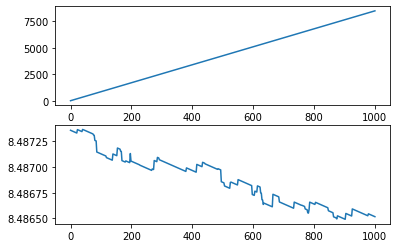

In [11]:
r = np.zeros(soln.r.shape[1])
v = np.zeros(soln.v.shape[1])
theta = np.zeros(soln.v.shape[1])
phi = np.zeros(soln.v.shape[1])
for i in range(3):
    r += soln.r[i, :] ** 2
    v += soln.v[i, :] ** 2
r = np.sqrt(r)
v = np.sqrt(v)

fig_1atm, ax_1atm = plt.subplots(2, 1)
ax_1atm[0].plot(soln.t, r, '-')
ax_1atm[1].plot(soln.t, v, '-')
print(soln.v.shape)

### Temperature

In [16]:
def solve_ensemble(num_atoms, t_evol, temp, delta, s):
    solns = []
    hamiltonian = return_hamiltonian(0.)
    laser_beams = return_lasers(delta, s)
    
    #progress = progressBar()
    for i in range(num_atoms):
        eqn = pylcp.rateeq(
            laser_beams, mag_field, hamiltonian,
            r0=np.zeros(3), v0=sample_velocity(mass, temp),
            include_mag_forces=True
        )
        eqn.set_initial_pop_from_equilibrium()
        soln = eqn.evolve_motion(
            [0, t], random_recoil=True,
            progress_bar=False
        )
        solns.append(soln)
        #progress.update((i + 1) / num_atoms)
    
    return solns

In [13]:
#solns = solve_ensemble(100, 1000., t_room, -2.0, 3.0)

In [14]:
# final temperature
def final_temp(solns):
    v_rms_sq = 0. # square of final rms velocity
    for i in range(100):
        for j in range(3):
            v_rms_sq += solns[i].v[j, -1] ** 2
    v_rms_sq = v_rms_sq / len(solns)
    temp = (1. / 3.) * mass * v_rms_sq
    return temp

In [17]:
s = np.array([1, 5, 10]) 
delta = np.linspace(-7.0, 0.0, num=10)
final_t = np.zeros((s.size, delta.size))

# define doppler temperature as a comparison point
t_doppler = 0.5

progress = progressBar()
for i in range(s.size):
    for j in range(delta.size):
        solns = solve_ensemble(10000, 1000., t_room, delta[j], s[i])
        final_t[i, j] = final_temp(solns)
        progress.update(float(i * s.size + j) / float(s.size * delta.size))

linestyle = ["o-g", "p-b", "v-k"]
fig_temp, ax_temp = plt.subplots()
for i in range(s.size):
    ax_temp.plot(delta, final_t[i, :] / t_doppler, \
                 label=string(s[i]))

KeyboardInterrupt: 